# 01 - Project Introduction: *What are the Meteorological Seasons?*

## Administrative boundaries data
The data are taken from [GADM](https://gadm.org/about.html), version 4.1. Data are distributed in GeoPackage format. Two different files are used:
- **WORLD**: contains the first level (countries) for the entire world (*data/gadm_410-levels.gpkg*)
- **INDIA**: contains the four administration levels of India (*data/gadm41_IND.gpkg*)



#### *Administrative division of India*
- Level 0: Country
- Level 1: States and union territories
- Level 2: District
- Level 3: Taluc

<sub><sup> *DISCLAIMER: Some regions in this area are disputed between states. The authors do not take responsibility for the borders shown, which are sourced from the GADM dataset.* </sup></sub>

In [63]:
import xarray as xr

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

In [31]:
#-- DECLARING DATA PATHS
# Weather data from ERA5
temperature_data_path   = '../data/preprocessed/ERA5/2m_temperature/temperature_15dd198*.nc'
precipitation_data_path = '../data/preprocessed/ERA5/total_precipitation/precipitation_15dd198*.nc'

# Geopackages with boundaries
country_boundary_file   = '../data/raw/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/raw/external/GADM41_WORLD.gpkg' 

#-- IMPORTING DATA
# Single xarray dataset for ERA5  

#dataset_temperature     = xr.open_mfdataset(temperature_data_path).var167.rename('t2m') - 273.15     # TO_DO move naming and standardization in preprocessing
#dataset_precipitation   = xr.open_mfdataset(precipitation_data_path).tp * 1000                        # TO_DO move naming and standardization in preprocessing


# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file, layer = 'ADM_0')

In [267]:
orography = xr.open_dataset('../data/raw/ERA5/static/ERA5_LAND_orog.nc')

# Load country boundary data
mask_boundary = gpd.read_file(world_boundary_file, layer='ADM_1')

orography = orography.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
orography.rio.write_crs("epsg:4326", inplace=True)
orography = orography.rio.clip(mask_boundary.geometry.apply(mapping), mask_boundary.crs, drop=True)

orography = orography.z.isel(time=0).rename('Elevation [m]') / 9.81

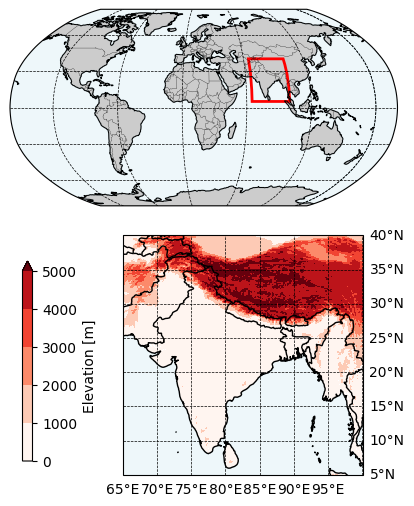

In [343]:
# Creating the figure
fig = plt.figure(figsize=(5, 5))

# Adding subplot with global map
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=20.0))
ax.set_global()
ax.coastlines(lw=0.7)
ax.add_feature(cfeature.BORDERS, linestyle='-', lw=0.2)
ax.add_feature(cfeature.LAND, color='gray', alpha=0.4)
ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)

# Add latitude and longitude grid lines
gl = ax.gridlines(draw_labels=False, linestyle='--', color='k', lw=0.5)

# Define extent of case study regions
regions = {
    "India": [65, 100, 5, 40],
    "Italy": [6, 19, 35, 49]
}

# Function for adding sub-map
def add_inset(extent, loc, orography, levels, ax_to_hide):

    # Cutting orography in the right extent
    orog = orography.sel(latitude = slice(extent[3], extent[2]), longitude = slice(extent[0], extent[1]))

    # Creating ax for sub map
    sub_ax = fig.add_axes(loc, projection=ccrs.PlateCarree())

    # Plotting orography in submap
    orog_plot = orog.plot(ax=sub_ax, add_colorbar=True, levels=levels, cmap='Reds', extend='max')
    #country_boundary.boundary.plot(ax = sub_ax, color='k', lw=0.5)

    # Manipulating colorbar position
    cbar_ax = orog_plot.colorbar.ax
    pos = sub_ax.get_position() 
    cbar_ax.set_position([pos.x0 - 0.20, pos.y0-0.01, 0.02, pos.height])

    # Setting gridlines in sub-map
    sub_ax.coastlines(lw=1)
    sub_ax.add_feature(cfeature.BORDERS, linestyle='-', lw=1)
    sub_ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)

    sub_ax.set_title('')

    # Add latitude and longitude grid lines
    gl = sub_ax.gridlines(draw_labels=True, linestyle='--', color='k', lw=0.5)

    if 'top' in ax_to_hide:
        gl.top_labels = False
    if 'left' in ax_to_hide:
        gl.left_labels = False
    if 'bottom' in ax_to_hide:
        gl.bottom_labels = False
    if 'right' in ax_to_hide:
        gl.right_labels = False
    

    # Aggiungi un box sulla mappa globale per indicare la regione zoomata
    rect = Rectangle((extent[0], extent[2]), extent[1] - extent[0], extent[3] - extent[2],
                     linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
    ax.add_patch(rect)


# Aggiungi le sotto-mappe per ciascuna regione
add_inset(regions["India"], [0.35, -0.30, 0.6, 0.6], orography, [0,1000,2000,3000,4000,5000], ['top','left'])
#add_inset(regions["Italy"], [0.35, 0.70, 0.6, 0.6], orography, [0,500,1000,1500,2000,2500,3000], ['bottom', 'left'])


plt.show()